In [82]:
import sys
import os
import gc
import warnings
import random
from copy import deepcopy
import random
import math

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.nn import Parameter
from torch.utils.data import Dataset, DataLoader
from madgrad import MADGRAD, MirrorMADGRAD
from torch.optim import AdamW
from transformers import (
    get_constant_schedule,
    get_constant_schedule_with_warmup,
    get_cosine_schedule_with_warmup,
    get_cosine_with_hard_restarts_schedule_with_warmup,
    get_linear_schedule_with_warmup,
    get_polynomial_decay_schedule_with_warmup
)
import cv2
from torchmetrics import F1Score

from sklearn.model_selection import StratifiedKFold, KFold
    
from tqdm.notebook import tqdm

warnings.filterwarnings("ignore")
tqdm.pandas()

In [51]:
PROJECT_DIR = "/content/drive/MyDrive/ml/Контесты/rucode_6/a"

# EDA

In [52]:
classes = ['Red', 'Green', 'Violet', 'White', 'Yellow', 'Brown', 'Black', 'Blue', 'Cyan', 'Grey', 'Orange']
counts = []
for class_name in classes:
    counts.append(len(os.listdir(f"./data/train/{class_name}")))

<BarContainer object of 11 artists>

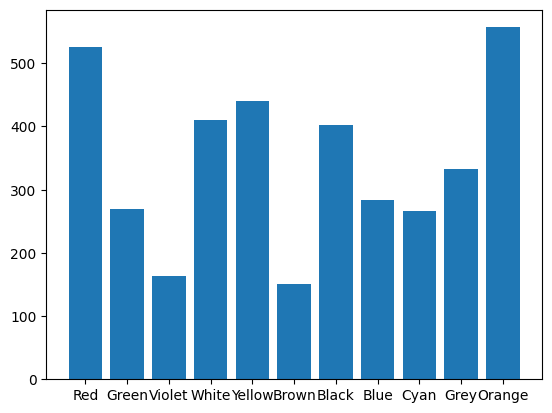

In [53]:
plt.bar(classes, counts)

# Dataset

In [126]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transforms=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(size=(256,256)),
    torchvision.transforms.Lambda(lambda a: a / 255),
#     torchvision.transforms.Normalize(mean, std)
])

In [65]:
train_dataset = torchvision.datasets.ImageFolder(f"./data/train", transform=transforms)

In [66]:
train_dataset.classes

['Black',
 'Blue',
 'Brown',
 'Cyan',
 'Green',
 'Grey',
 'Orange',
 'Red',
 'Violet',
 'White',
 'Yellow']

# Losses

In [67]:
class FocalLoss(nn.Module):
    def __init__(self, weight, gamma=0, eps=1e-7):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.eps = eps
        self.ce = torch.nn.CrossEntropyLoss(weight=weight)

    def forward(self, input, target):
        logp = self.ce(input, target)
        p = torch.exp(-logp)
        loss = (1 - p) ** self.gamma * logp
        return loss.mean()


class ArcFaceLoss(nn.Module):
    def __init__(self, s=45.0, m=0.1, crit="bce", weight=None, reduction="mean",
                 focal_loss_gamma=0, class_weights_norm="batch"):
        super().__init__()

        self.weight = weight
        self.reduction = reduction
        self.class_weights_norm = class_weights_norm
        
        if crit == "focal":
            self.crit = FocalLoss(gamma=focal_loss_gamma)
        elif crit == "bce":
            self.crit = nn.CrossEntropyLoss(reduction="none")   

        if s is None:
            self.s = torch.nn.Parameter(torch.tensor([45.], requires_grad=True, device='cuda'))
        else:
            self.s = s

        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m
        
    def forward(self, logits, labels):

        logits = logits.float()
        cosine = logits
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        
        labels2 = torch.zeros_like(cosine)
        labels2.scatter_(1, labels.view(-1, 1).long(), 1)
        labels2 *= (1 - 0.1)
        labels2 += 0.005
        output = (labels2 * phi) + ((1.0 - labels2) * cosine)

        s = self.s

        output = output * s
        loss = self.crit(output, labels)

        if self.weight is not None:
            w = self.weight[labels].to(logits.device)

            loss = loss * w
            if self.class_weights_norm == "batch":
                loss = loss.sum() / w.sum()
            if self.class_weights_norm == "global":
                loss = loss.mean()
            else:
                loss = loss.mean()
            
            return loss
        if self.reduction == "mean":
            loss = loss.mean()
        elif self.reduction == "sum":
            loss = loss.sum()
        return loss

# Modules

In [68]:
class ArcMarginProduct(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight)

    def forward(self, features):
        cosine = F.linear(F.normalize(features), F.normalize(self.weight))
        return cosine

# Model

In [69]:
class ResNet(nn.Module):
    def __init__(self, backbone, output_dim):
        super().__init__()
        self.backbone = backbone
        del backbone.fc
        self.backbone.dropout = nn.Dropout(p=0.1)
        self.backbone.fc = torch.nn.Linear(in_features=2048, out_features=output_dim, bias=True)
        
    def forward(self, image):
        out = self.backbone(image)
#         out = self.out(x)
        return out

# Loops

In [98]:
def train_epoch(model, data_loader, loss_function, optimizer, scheduler, device):
    model.to(device)
    model.train()
    total_train_loss = 0
    
    f1 = F1Score(num_classes=11, average='macro').to(device)

    dl_size = len(data_loader)
    
    preds = []
    targets = []

    batch_i = 0

    for batch in tqdm(data_loader):
        image, target = batch
        image = image.to(device)
        target = target.to(device)
        
        optimizer.zero_grad()        
        logits = model(image)
        
        preds.append(logits.argmax(dim=1))
        targets.append(target)
                
        loss = loss_function(logits, target)
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    
    preds = torch.cat(preds, dim=0)
    targets = torch.cat(targets, dim=0)
    acc = (targets == preds).sum() / preds.shape[0]
    f1_score = f1(preds, targets)
    
    metrics = {
        "Train Loss": total_train_loss / dl_size,
        "Train Accuracy": acc.item(),
        "Train F1": f1_score.item()
    }
    
    
    return metrics
    
    
def eval_epoch(model, data_loader, loss_function, device):
    model.to(device)
    model.eval()
    total_train_loss = 0
    
    f1 = F1Score(num_classes=11, average='macro').to(device)
    
    preds = []
    targets = []

    dl_size = len(data_loader)

    
    for batch in tqdm(data_loader):
        image, target = batch
        image = image.to(device)
        target = target.to(device)
        
        with torch.no_grad():
            logits = model(image)
            preds.append(logits.argmax(dim=1))
            targets.append(target)
        
        loss = loss_function(logits, target)
        total_train_loss += loss.item()
    
    preds = torch.cat(preds, dim=0)
    targets = torch.cat(targets, dim=0)
    acc = (targets == preds).sum() / preds.shape[0]
    f1_score = f1(preds, targets)
    
    metrics = {
        "Eval Loss": total_train_loss / dl_size,
        "Eval Accuracy": acc.item(),
        "Eval F1": f1_score.item()
    }
    
    return metrics

In [101]:
def cross_validation(project_name,
    model, 
                     dataset, 
                     loss_function, 
                     strat_array=None,
                     device=torch.device("cuda"),
                     random_state: int=69, 
                     shuffle: bool=True, 
                     n_folds: int=4, 
                     epochs: int=5, 
                     lr: float=1e-6,
                     start_fold: int=0, 
                     batch_size: int=32,
                     iters_to_accumulate=None):
    random.seed(random_state),
    np.random.seed(random_state)
    torch.manual_seed(random_state)
    torch.cuda.manual_seed_all(random_state)
    
    loss_function.to(device)
    if strat_array:
        kfold = StratifiedKFold(n_folds, shuffle=shuffle, random_state=random_state)
        split = kfold.split(dataset, strat_array)
    else: 
        kfold = KFold(n_folds, shuffle=shuffle, random_state=random_state)
        split = kfold.split(dataset)

    for fold, (train_ids, eval_ids) in enumerate(split):
        if fold >= start_fold:
            print(f'FOLD {fold}')
            print('--------------------------------')
            
            for p in model.parameters():
                if p.dim() > 1:
                    nn.init.xavier_uniform_(p)
                else:
                    nn.init.normal_(p)
            
            run = wandb.init(
                name=f"fold_{fold}",
                project=f"{project_name}_fold_{fold}",
                config={ 
                         "random_state": random_state, 
                         "shuffle": shuffle,
                         "epochs": epochs, 
                         "learning_rate": lr,
                         "batch_size": batch_size,
                         "iters_to_accumulate": iters_to_accumulate
                        }
            )


            optimizer = torch.optim.AdamW(
                model.parameters(),
                lr = lr, # args.learning_rate - default is 5e-5, our notebook had 2e-5
            )
            
            train_subsampler = torch.utils.data.Subset(dataset,  train_ids)
            train_loader = torch.utils.data.DataLoader(
                          train_subsampler, 
                          batch_size=batch_size,
                          shuffle=shuffle)

            eval_subsampler = torch.utils.data.Subset(dataset,  eval_ids)
            eval_loader = torch.utils.data.DataLoader(
                          eval_subsampler,
                          batch_size=batch_size,
                          shuffle=shuffle)
            
            total_steps = len(train_loader) * epochs 

            scheduler = get_cosine_schedule_with_warmup(optimizer, 
                                                    num_warmup_steps = 0, # Default value in run_glue.py
                                                    num_training_steps = total_steps)

            mrrs = []

            for epoch_i in range(0, epochs):
                train_metrics = train_epoch(model, train_loader, loss_function, optimizer, scheduler, device)
                eval_metrics = eval_epoch(model, eval_loader, loss_function, device)
                
                print(f"EPOCH: {epoch_i}")
                print(train_metrics)
                print(eval_metrics)
                
                run.log(train_metrics)
                run.log(eval_metrics)
                            
            run.finish()


def single_model(model, 
                     dataset, 
                     loss_function, 
                     device=torch.device("cuda"),
                     random_state: int=69, 
                     shuffle=True,
                     epochs: int=15, 
                     lr: float=1e-6,
                     batch_size: int=32,
                     start_epoch=0
                     ):
    random.seed(random_state),
    np.random.seed(random_state)
    torch.manual_seed(random_state)
    torch.cuda.manual_seed_all(random_state)
    
    loss_function.to(device)
    model.to(device)

    optimizer = MADGRAD(
        model.parameters(),
        lr = lr, # args.learning_rate - default is 5e-5, our notebook had 2e-5
    )

    data_loader = torch.utils.data.DataLoader(
                    dataset,
                    batch_size=batch_size,
                    shuffle=shuffle
    )
    
    total_steps = len(data_loader) * epochs 

    scheduler = get_cosine_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

    for epoch_i in range(0, epochs):
        if epoch_i >= start_epoch:
            train_metrics = train_epoch(model, data_loader, loss_function, optimizer, scheduler, device)
            print("EPOCH", epoch_i)
            print(train_metrics)
            # eval_epoch(fold_model, eval_loader, loss_function, device)

# Cross Validation

In [72]:
!nvidia-smi

Mon Nov 14 02:15:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.56.06    Driver Version: 520.56.06    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:05:00.0  On |                  Off |
|  0%   34C    P8    20W / 450W |    280MiB / 24564MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [73]:
strat_array = []
target_class = 0
for folder in tqdm(os.listdir('data/train')):
    for _ in range(len(os.listdir('data/train'+f'/{folder}'))):
        strat_array.append(target_class)
    target_class += 1

  0%|          | 0/11 [00:00<?, ?it/s]

In [74]:
n = len(strat_array)
weights = []
for i in range(11):
    weights.append((strat_array.count(i) / n))
    
correct_weights = []
for i in range(11):
    correct_weights.append(weights[i] / sum(weights))
    
correct_weights

[0.039452919516044196,
 0.14650184113624412,
 0.04287217254076802,
 0.10573382430299844,
 0.11572856391372963,
 0.08758548132561811,
 0.13834823776959498,
 0.10810099947396108,
 0.07022619673855866,
 0.07469752761704368,
 0.07075223566543926]

In [76]:
# backbone = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1)
model_weights = torch.load('model.pt', map_location=torch.device('cpu'))
backbone = torchvision.models.resnet50(weights=model_weights)

In [77]:
model = ResNet(backbone, 11)

In [78]:
loss_function=FocalLoss(weight=torch.tensor(correct_weights))

In [91]:
import wandb

In [100]:
cross_validation(project_name="car_classification",
                     model=model, 
                     dataset=train_dataset,
                     strat_array=strat_array,
                     loss_function=loss_function, 
                     device=torch.device("cuda"),
                     random_state=69, 
                     n_folds=4, 
                     epochs=15, 
                     lr=1e-4,
                     start_fold=0, 
                     batch_size=16)

FOLD 0
--------------------------------


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 0
{'Train Loss': 1.206027832610647, 'Train Accuracy': 0.5804980993270874, 'Train F1': 0.5288954377174377}
{'Eval Loss': 0.7690187782049179, 'Eval Accuracy': 0.7013669610023499, 'Eval F1': 0.5946371555328369}


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 1
{'Train Loss': 0.6803299045429549, 'Train Accuracy': 0.750613808631897, 'Train F1': 0.7163687944412231}
{'Eval Loss': 0.5199573947427173, 'Eval Accuracy': 0.8138800859451294, 'Eval F1': 0.7512196898460388}


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 2
{'Train Loss': 0.4522818772319975, 'Train Accuracy': 0.8284812569618225, 'Train F1': 0.7965662479400635}
{'Eval Loss': 0.48611115760480367, 'Eval Accuracy': 0.8317559957504272, 'Eval F1': 0.7856879234313965}


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 3
{'Train Loss': 0.362162391722785, 'Train Accuracy': 0.8688179850578308, 'Train F1': 0.8484314680099487}
{'Eval Loss': 0.40632665194571016, 'Eval Accuracy': 0.8443742990493774, 'Eval F1': 0.8118723630905151}


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 4
{'Train Loss': 0.2896387399221099, 'Train Accuracy': 0.8905647397041321, 'Train F1': 0.8699716925621033}
{'Eval Loss': 0.36096606073745835, 'Eval Accuracy': 0.8601471781730652, 'Eval F1': 0.8263582587242126}


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 5
{'Train Loss': 0.19694806555775124, 'Train Accuracy': 0.9242371320724487, 'Train F1': 0.9138675928115845}
{'Eval Loss': 0.3191102793129782, 'Eval Accuracy': 0.8916928768157959, 'Eval F1': 0.8699156045913696}


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 6
{'Train Loss': 0.16134266399742006, 'Train Accuracy': 0.9449316263198853, 'Train F1': 0.9363938570022583}
{'Eval Loss': 0.22888081791849496, 'Eval Accuracy': 0.9211356043815613, 'Eval F1': 0.9011916518211365}


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 7
{'Train Loss': 0.12265918528327495, 'Train Accuracy': 0.9540511965751648, 'Train F1': 0.9464216828346252}
{'Eval Loss': 0.23990487112508466, 'Eval Accuracy': 0.9390115141868591, 'Eval F1': 0.9320517778396606}


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 8
{'Train Loss': 0.08879368332178558, 'Train Accuracy': 0.9670291543006897, 'Train F1': 0.961477518081665}
{'Eval Loss': 0.2585487755583017, 'Eval Accuracy': 0.9316508173942566, 'Eval F1': 0.9089640378952026}


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 9
{'Train Loss': 0.03946421148848763, 'Train Accuracy': 0.9842160940170288, 'Train F1': 0.9825594425201416}
{'Eval Loss': 0.2200930011866755, 'Eval Accuracy': 0.9348053932189941, 'Eval F1': 0.921311616897583}


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 10
{'Train Loss': 0.03523135237029039, 'Train Accuracy': 0.988775908946991, 'Train F1': 0.985552191734314}
{'Eval Loss': 0.23361333541373216, 'Eval Accuracy': 0.9432176351547241, 'Eval F1': 0.9314178228378296}


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 11
{'Train Loss': 0.020497887157441188, 'Train Accuracy': 0.9940372109413147, 'Train F1': 0.992911696434021}
{'Eval Loss': 0.2264195087887856, 'Eval Accuracy': 0.936908483505249, 'Eval F1': 0.9251270890235901}


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 12
{'Train Loss': 0.009071807828063381, 'Train Accuracy': 0.9971939921379089, 'Train F1': 0.9968069791793823}
{'Eval Loss': 0.1997984171903833, 'Eval Accuracy': 0.9432176351547241, 'Eval F1': 0.9264184236526489}


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 13
{'Train Loss': 0.006475361739711584, 'Train Accuracy': 0.9978954792022705, 'Train F1': 0.997696042060852}
{'Eval Loss': 0.19444234808430944, 'Eval Accuracy': 0.9453206658363342, 'Eval F1': 0.9301608204841614}


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 14
{'Train Loss': 0.010590859744564383, 'Train Accuracy': 0.9971939921379089, 'Train F1': 0.9968841075897217}
{'Eval Loss': 0.20474638134073758, 'Eval Accuracy': 0.9411145448684692, 'Eval F1': 0.9260197877883911}


Eval Accuracy,▁▄▅▅▆▆▇████████
Eval F1,▁▄▅▆▆▇▇████████
Eval Loss,█▅▅▄▃▃▁▂▂▁▁▁▁▁▁
Train Accuracy,▁▄▅▆▆▇▇▇▇██████
Train F1,▁▄▅▆▆▇▇▇▇██████
Train Loss,█▅▄▃▃▂▂▂▁▁▁▁▁▁▁
Eval Accuracy,0.94111
Eval F1,0.92602
Eval Loss,0.20475
Train Accuracy,0.99719
Train F1,0.99688


FOLD 1
--------------------------------


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 0
{'Train Loss': 1.1686741431665155, 'Train Accuracy': 0.5885654091835022, 'Train F1': 0.5254381895065308}
{'Eval Loss': 1.181006881594658, 'Eval Accuracy': 0.6466876864433289, 'Eval F1': 0.5802657604217529}


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 1
{'Train Loss': 0.6045928946670207, 'Train Accuracy': 0.7814801931381226, 'Train F1': 0.7465054392814636}
{'Eval Loss': 0.9340935950477918, 'Eval Accuracy': 0.7181913256645203, 'Eval F1': 0.6888308525085449}


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 2
{'Train Loss': 0.46112357383573105, 'Train Accuracy': 0.8351455926895142, 'Train F1': 0.8068413734436035}
{'Eval Loss': 0.35423375898972154, 'Eval Accuracy': 0.8801261186599731, 'Eval F1': 0.8711382150650024}


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 3
{'Train Loss': 0.36147503528286123, 'Train Accuracy': 0.8681164383888245, 'Train F1': 0.8424882888793945}
{'Eval Loss': 0.2921492524134616, 'Eval Accuracy': 0.902208149433136, 'Eval F1': 0.8929318189620972}


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 4
{'Train Loss': 0.31059356454458065, 'Train Accuracy': 0.8891617059707642, 'Train F1': 0.8710260391235352}
{'Eval Loss': 0.28474499789687496, 'Eval Accuracy': 0.8948474526405334, 'Eval F1': 0.8741713762283325}


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 5
{'Train Loss': 0.22487247550753386, 'Train Accuracy': 0.9228340983390808, 'Train F1': 0.9106817245483398}
{'Eval Loss': 0.5532456142711453, 'Eval Accuracy': 0.8454258441925049, 'Eval F1': 0.8151421546936035}


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 6
{'Train Loss': 0.1589761024962736, 'Train Accuracy': 0.9431778192520142, 'Train F1': 0.9331564903259277}
{'Eval Loss': 0.19251047592842951, 'Eval Accuracy': 0.9242901802062988, 'Eval F1': 0.9131983518600464}


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 7
{'Train Loss': 0.12595775699946643, 'Train Accuracy': 0.9551034569740295, 'Train F1': 0.9477915167808533}
{'Eval Loss': 0.22156897968695072, 'Eval Accuracy': 0.9295477867126465, 'Eval F1': 0.9182320833206177}


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 8
{'Train Loss': 0.08500910101986202, 'Train Accuracy': 0.9740442037582397, 'Train F1': 0.9686589241027832}
{'Eval Loss': 0.15263176784016347, 'Eval Accuracy': 0.9516298174858093, 'Eval F1': 0.9458949565887451}


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 9
{'Train Loss': 0.04565490761323209, 'Train Accuracy': 0.981410026550293, 'Train F1': 0.9792953729629517}
{'Eval Loss': 0.12667924768732822, 'Eval Accuracy': 0.9516298174858093, 'Eval F1': 0.9458959102630615}


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 10
{'Train Loss': 0.026451427933921603, 'Train Accuracy': 0.988775908946991, 'Train F1': 0.9867657423019409}
{'Eval Loss': 0.13354218784645583, 'Eval Accuracy': 0.9537328481674194, 'Eval F1': 0.9482322931289673}


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 11
{'Train Loss': 0.019459002439458476, 'Train Accuracy': 0.9926341772079468, 'Train F1': 0.9910745620727539}
{'Eval Loss': 0.13228451939242708, 'Eval Accuracy': 0.9537328481674194, 'Eval F1': 0.9473649859428406}


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 12
{'Train Loss': 0.011575912305864593, 'Train Accuracy': 0.9954401850700378, 'Train F1': 0.9935382604598999}
{'Eval Loss': 0.13024350018301145, 'Eval Accuracy': 0.9516298174858093, 'Eval F1': 0.9456961154937744}


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 13
{'Train Loss': 0.023655902623843317, 'Train Accuracy': 0.9936864376068115, 'Train F1': 0.9934529066085815}
{'Eval Loss': 0.1325066721959312, 'Eval Accuracy': 0.9631965756416321, 'Eval F1': 0.95680832862854}


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 14
{'Train Loss': 0.01534339628825725, 'Train Accuracy': 0.9961417317390442, 'Train F1': 0.9956860542297363}
{'Eval Loss': 0.12316232947020277, 'Eval Accuracy': 0.9589904546737671, 'Eval F1': 0.9527356624603271}


Eval Accuracy,▁▃▆▇▆▅▇▇███████
Eval F1,▁▃▆▇▆▅▇▇███████
Eval Loss,█▆▃▂▂▄▁▂▁▁▁▁▁▁▁
Train Accuracy,▁▄▅▆▆▇▇▇███████
Train F1,▁▄▅▆▆▇▇▇███████
Train Loss,█▅▄▃▃▂▂▂▁▁▁▁▁▁▁
Eval Accuracy,0.95899
Eval F1,0.95274
Eval Loss,0.12316
Train Accuracy,0.99614
Train F1,0.99569


FOLD 2
--------------------------------


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 0
{'Train Loss': 1.216193356743738, 'Train Accuracy': 0.5992286205291748, 'Train F1': 0.5537733435630798}
{'Eval Loss': 0.9540216679374377, 'Eval Accuracy': 0.6526315212249756, 'Eval F1': 0.5990362763404846}


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 1
{'Train Loss': 0.6462006387847096, 'Train Accuracy': 0.7784011363983154, 'Train F1': 0.7446829080581665}
{'Eval Loss': 0.4714232883105675, 'Eval Accuracy': 0.8294736742973328, 'Eval F1': 0.7929366230964661}


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 2
{'Train Loss': 0.4646601611904425, 'Train Accuracy': 0.833450198173523, 'Train F1': 0.8065221309661865}
{'Eval Loss': 0.38928950888415176, 'Eval Accuracy': 0.8494736552238464, 'Eval F1': 0.7810969352722168}


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 3
{'Train Loss': 0.3607943411240115, 'Train Accuracy': 0.8723702430725098, 'Train F1': 0.8468042016029358}
{'Eval Loss': 0.39341923165290305, 'Eval Accuracy': 0.8536841869354248, 'Eval F1': 0.8315707445144653}


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 4
{'Train Loss': 0.3043130622417718, 'Train Accuracy': 0.8934081196784973, 'Train F1': 0.8765314817428589}
{'Eval Loss': 0.4109379732903714, 'Eval Accuracy': 0.8768420815467834, 'Eval F1': 0.8546889424324036}


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 5
{'Train Loss': 0.18798015550996422, 'Train Accuracy': 0.9235624074935913, 'Train F1': 0.9108206033706665}
{'Eval Loss': 0.3538347419758793, 'Eval Accuracy': 0.8947368264198303, 'Eval F1': 0.8768051266670227}


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 6
{'Train Loss': 0.19237944332839838, 'Train Accuracy': 0.9382889270782471, 'Train F1': 0.9272258877754211}
{'Eval Loss': 0.21520580561288322, 'Eval Accuracy': 0.9210525751113892, 'Eval F1': 0.9129036068916321}


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 7
{'Train Loss': 0.1157735050442907, 'Train Accuracy': 0.9586254954338074, 'Train F1': 0.9522827863693237}
{'Eval Loss': 0.2030708511483681, 'Eval Accuracy': 0.9284210205078125, 'Eval F1': 0.9108445644378662}


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 8
{'Train Loss': 0.07934103846012136, 'Train Accuracy': 0.972300112247467, 'Train F1': 0.9674448370933533}
{'Eval Loss': 0.269803311280945, 'Eval Accuracy': 0.9273684024810791, 'Eval F1': 0.9194291830062866}


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 9
{'Train Loss': 0.05606257334038064, 'Train Accuracy': 0.9810659289360046, 'Train F1': 0.9798194169998169}
{'Eval Loss': 0.14302598053460922, 'Eval Accuracy': 0.9515789151191711, 'Eval F1': 0.9415123462677002}


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 10
{'Train Loss': 0.037522837091217794, 'Train Accuracy': 0.9884291887283325, 'Train F1': 0.9875025749206543}
{'Eval Loss': 0.17865765797587302, 'Eval Accuracy': 0.9473683834075928, 'Eval F1': 0.9426257610321045}


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 11
{'Train Loss': 0.024346352730801768, 'Train Accuracy': 0.9901823401451111, 'Train F1': 0.9889352321624756}
{'Eval Loss': 0.14449566257402088, 'Eval Accuracy': 0.9557894468307495, 'Eval F1': 0.9493106603622437}


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 12
{'Train Loss': 0.02407959268595082, 'Train Accuracy': 0.9919354915618896, 'Train F1': 0.9917327165603638}
{'Eval Loss': 0.1415605562874892, 'Eval Accuracy': 0.9578946828842163, 'Eval F1': 0.9516195058822632}


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 13
{'Train Loss': 0.019171566817407965, 'Train Accuracy': 0.9936886429786682, 'Train F1': 0.9930331110954285}
{'Eval Loss': 0.13942018512764964, 'Eval Accuracy': 0.9547367691993713, 'Eval F1': 0.9490979909896851}


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 14
{'Train Loss': 0.014358155902417359, 'Train Accuracy': 0.9957923889160156, 'Train F1': 0.9955132007598877}
{'Eval Loss': 0.142611436743573, 'Eval Accuracy': 0.9557894468307495, 'Eval F1': 0.9490594863891602}


Eval Accuracy,▁▅▆▆▆▇▇▇▇██████
Eval F1,▁▅▅▆▆▇▇▇▇██████
Eval Loss,█▄▃▃▃▃▂▂▂▁▁▁▁▁▁
Train Accuracy,▁▄▅▆▆▇▇▇███████
Train F1,▁▄▅▆▆▇▇▇███████
Train Loss,█▅▄▃▃▂▂▂▁▁▁▁▁▁▁
Eval Accuracy,0.95579
Eval F1,0.94906
Eval Loss,0.14261
Train Accuracy,0.99579
Train F1,0.99551


FOLD 3
--------------------------------


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 0
{'Train Loss': 1.269089275773344, 'Train Accuracy': 0.562762975692749, 'Train F1': 0.4888371229171753}
{'Eval Loss': 0.7583236753940582, 'Eval Accuracy': 0.7505263090133667, 'Eval F1': 0.7183271646499634}


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 1
{'Train Loss': 0.6661682201330889, 'Train Accuracy': 0.7559607028961182, 'Train F1': 0.7102352380752563}
{'Eval Loss': 1.2554156069954236, 'Eval Accuracy': 0.6315789222717285, 'Eval F1': 0.5894994735717773}


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 2
{'Train Loss': 0.49786733217828766, 'Train Accuracy': 0.8194249868392944, 'Train F1': 0.7925637364387512}
{'Eval Loss': 0.7507310620819528, 'Eval Accuracy': 0.7852631211280823, 'Eval F1': 0.7303613424301147}


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 3
{'Train Loss': 0.42433207823411045, 'Train Accuracy': 0.8492286205291748, 'Train F1': 0.8219056129455566}
{'Eval Loss': 0.342473446795096, 'Eval Accuracy': 0.8389473557472229, 'Eval F1': 0.8207679986953735}


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 4
{'Train Loss': 0.2843249155749572, 'Train Accuracy': 0.8892005681991577, 'Train F1': 0.8691785931587219}
{'Eval Loss': 0.1916252349736169, 'Eval Accuracy': 0.9168420433998108, 'Eval F1': 0.8861446976661682}


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 5
{'Train Loss': 0.23133420928149853, 'Train Accuracy': 0.920406699180603, 'Train F1': 0.906629204750061}
{'Eval Loss': 0.20703290279100958, 'Eval Accuracy': 0.9199999570846558, 'Eval F1': 0.9089107513427734}


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 6
{'Train Loss': 0.16708277468569577, 'Train Accuracy': 0.9344319701194763, 'Train F1': 0.9227640628814697}
{'Eval Loss': 0.14460995937600576, 'Eval Accuracy': 0.9505262970924377, 'Eval F1': 0.9451263546943665}


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 7
{'Train Loss': 0.11600688846057343, 'Train Accuracy': 0.95652174949646, 'Train F1': 0.9499514102935791}
{'Eval Loss': 0.21864486304451322, 'Eval Accuracy': 0.9378947019577026, 'Eval F1': 0.9252363443374634}


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 8
{'Train Loss': 0.0730227049686959, 'Train Accuracy': 0.9680925607681274, 'Train F1': 0.9617003798484802}
{'Eval Loss': 0.19913122010305717, 'Eval Accuracy': 0.9368420839309692, 'Eval F1': 0.9325398206710815}


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 9
{'Train Loss': 0.042988186343374674, 'Train Accuracy': 0.9828190803527832, 'Train F1': 0.9805868864059448}
{'Eval Loss': 0.16921722938289652, 'Eval Accuracy': 0.9515789151191711, 'Eval F1': 0.9466652870178223}


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 10
{'Train Loss': 0.033150562582923364, 'Train Accuracy': 0.9887797832489014, 'Train F1': 0.9863224029541016}
{'Eval Loss': 0.1485904180218616, 'Eval Accuracy': 0.9610525965690613, 'Eval F1': 0.9563497304916382}


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 11
{'Train Loss': 0.018666497699462894, 'Train Accuracy': 0.9926367402076721, 'Train F1': 0.9910616278648376}
{'Eval Loss': 0.1570683401843174, 'Eval Accuracy': 0.9578946828842163, 'Eval F1': 0.9536164999008179}


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 12
{'Train Loss': 0.016585983143524784, 'Train Accuracy': 0.9957923889160156, 'Train F1': 0.9949502944946289}
{'Eval Loss': 0.1349813709775238, 'Eval Accuracy': 0.9599999785423279, 'Eval F1': 0.9570445418357849}


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 13
{'Train Loss': 0.0106322869105599, 'Train Accuracy': 0.9936886429786682, 'Train F1': 0.9922493696212769}
{'Eval Loss': 0.150082976309083, 'Eval Accuracy': 0.9610525965690613, 'Eval F1': 0.9590008854866028}


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

EPOCH: 14
{'Train Loss': 0.008783793092014134, 'Train Accuracy': 0.9964936971664429, 'Train F1': 0.996343731880188}
{'Eval Loss': 0.14270041909103384, 'Eval Accuracy': 0.9589473009109497, 'Eval F1': 0.9559458494186401}


Eval Accuracy,▄▁▄▅▇▇██▇██████
Eval F1,▃▁▄▅▇▇█▇▇██████
Eval Loss,▅█▅▂▁▁▁▂▁▁▁▁▁▁▁
Train Accuracy,▁▄▅▆▆▇▇▇███████
Train F1,▁▄▅▆▆▇▇▇███████
Train Loss,█▅▄▃▃▂▂▂▁▁▁▁▁▁▁
Eval Accuracy,0.95895
Eval F1,0.95595
Eval Loss,0.1427
Train Accuracy,0.99649
Train F1,0.99634


In [102]:
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
    else:
        nn.init.normal_(p)

In [103]:
single_model(model, 
            train_dataset, 
            loss_function, 
            device = torch.device("cuda"),
            random_state = 69, 
            shuffle = True,
            epochs = 15, 
            lr = 1e-4,
            batch_size = 16,
)

  0%|          | 0/238 [00:00<?, ?it/s]

EPOCH 0
{'Train Loss': 1.4224906693987485, 'Train Accuracy': 0.5410310626029968, 'Train F1': 0.47948479652404785}


  0%|          | 0/238 [00:00<?, ?it/s]

EPOCH 1
{'Train Loss': 0.8717264978199446, 'Train Accuracy': 0.724881649017334, 'Train F1': 0.682211697101593}


  0%|          | 0/238 [00:00<?, ?it/s]

EPOCH 2
{'Train Loss': 0.6325532395956146, 'Train Accuracy': 0.7961599230766296, 'Train F1': 0.762059211730957}


  0%|          | 0/238 [00:00<?, ?it/s]

EPOCH 3
{'Train Loss': 0.5345744930027726, 'Train Accuracy': 0.8237769603729248, 'Train F1': 0.7938148975372314}


  0%|          | 0/238 [00:00<?, ?it/s]

EPOCH 4
{'Train Loss': 0.42044572367043304, 'Train Accuracy': 0.853235125541687, 'Train F1': 0.8268512487411499}


  0%|          | 0/238 [00:00<?, ?it/s]

EPOCH 5
{'Train Loss': 0.41331222095378056, 'Train Accuracy': 0.8677012324333191, 'Train F1': 0.8455914855003357}


  0%|          | 0/238 [00:00<?, ?it/s]

EPOCH 6
{'Train Loss': 0.29861516320193576, 'Train Accuracy': 0.9003156423568726, 'Train F1': 0.8824159502983093}


  0%|          | 0/238 [00:00<?, ?it/s]

EPOCH 7
{'Train Loss': 0.22874298493452214, 'Train Accuracy': 0.918463945388794, 'Train F1': 0.9056546092033386}


  0%|          | 0/238 [00:00<?, ?it/s]

EPOCH 8
{'Train Loss': 0.15206423672962888, 'Train Accuracy': 0.9445028901100159, 'Train F1': 0.9356182813644409}


  0%|          | 0/238 [00:00<?, ?it/s]

EPOCH 9
{'Train Loss': 0.13096436782262655, 'Train Accuracy': 0.9550237059593201, 'Train F1': 0.9498615264892578}


  0%|          | 0/238 [00:00<?, ?it/s]

EPOCH 10
{'Train Loss': 0.0669852750541074, 'Train Accuracy': 0.9742240905761719, 'Train F1': 0.9694836139678955}


  0%|          | 0/238 [00:00<?, ?it/s]

EPOCH 11
{'Train Loss': 0.05176696170475079, 'Train Accuracy': 0.9807995557785034, 'Train F1': 0.9775157570838928}


  0%|          | 0/238 [00:00<?, ?it/s]

EPOCH 12
{'Train Loss': 0.02293531569103689, 'Train Accuracy': 0.9897422194480896, 'Train F1': 0.9877159595489502}


  0%|          | 0/238 [00:00<?, ?it/s]

EPOCH 13
{'Train Loss': 0.0176871992144361, 'Train Accuracy': 0.9915834069252014, 'Train F1': 0.9903436899185181}


  0%|          | 0/238 [00:00<?, ?it/s]

EPOCH 14
{'Train Loss': 0.017543350774338082, 'Train Accuracy': 0.9934245347976685, 'Train F1': 0.9930216073989868}


In [153]:
def predict(model, device, root=f"./data/public_test/", transform=transforms):
    model.eval()
    model.to(device)
    
    preds = []
    
    img_files = sorted(os.listdir(root))
    print(img_files)
    for img_file in tqdm(img_files):
        img_bgr = cv2.imread(root + img_file)
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        image = transform(img_rgb).to(device)
        
        with torch.no_grad():
            pred = model(image.unsqueeze(dim=0)).argmax(dim=1).cpu().item()
            preds.append(pred)
            
    return pd.Series(preds)

In [154]:
preds = predict(model, device=torch.device("cuda"), root=f"./data/public_test/", transform=transforms)

['0.jpg', '1.jpg', '10.jpg', '100.jpg', '1000.jpg', '1001.jpg', '1002.jpg', '1003.jpg', '1004.jpg', '1005.jpg', '1006.jpg', '1007.jpg', '1008.jpg', '1009.jpg', '101.jpg', '1010.jpg', '1011.jpg', '1012.jpg', '1013.jpg', '1014.jpg', '1015.jpg', '1016.jpg', '1017.jpg', '1018.jpg', '1019.jpg', '102.jpg', '1020.jpg', '1021.jpg', '1022.jpg', '1023.jpg', '1024.jpg', '1025.jpg', '1026.jpg', '1027.jpg', '1028.jpg', '1029.jpg', '103.jpg', '1030.jpg', '1031.jpg', '1032.jpg', '1033.jpg', '1034.jpg', '1035.jpg', '1036.jpg', '1037.jpg', '1038.jpg', '1039.jpg', '104.jpg', '1040.jpg', '1041.jpg', '1042.jpg', '1043.jpg', '1044.jpg', '1045.jpg', '1046.jpg', '1047.jpg', '1048.jpg', '1049.jpg', '105.jpg', '1050.jpg', '1051.jpg', '1052.jpg', '1053.jpg', '1054.jpg', '1055.jpg', '1056.jpg', '1057.jpg', '1058.jpg', '1059.jpg', '106.jpg', '1060.jpg', '1061.jpg', '1062.jpg', '1063.jpg', '1064.jpg', '1065.jpg', '1066.jpg', '1067.jpg', '1068.jpg', '1069.jpg', '107.jpg', '1070.jpg', '1071.jpg', '1072.jpg', '1073.j

  0%|          | 0/1436 [00:00<?, ?it/s]

In [155]:
preds = preds.apply(lambda x: train_dataset.classes[x])

In [156]:
preds.to_csv("baseline_submission.csv", index=False)